## Tutorial 09 - Advection Dominated problem
**_Keywords: POD-Galerkin method, SUPG_**

### 1. Introduction
This tutorial addresses the POD-Galerkin method to the advection dominated worked problem in a two-dimensional domain $\Omega=(0,1)^2$.

We introduce a stabilization technique such as $\textit{Streamline/Upwind Petrov-Galerkin}$ (SUPG) able to reduce the numerical oscillations on the approximation of the solution of parametrized advection-diffusion problem:

$$
-\varepsilon(\boldsymbol{\mu})\,\Delta u(\boldsymbol{\mu})+\beta(\boldsymbol{\mu})\cdot\nabla u(\boldsymbol{\mu})=f(\boldsymbol{\mu})\quad\text{on }\,\Omega(\boldsymbol{\mu}),
$$

where $\beta(\boldsymbol{\mu})$ and $\varepsilon(\boldsymbol{\mu})$ represent the advection and the diffusion term, respectively.

For this problem, we consider on parameter $\mu$, thus $P=1$. It is related to the Péclet number:

$$
\mathbb{P}e_K(\boldsymbol{\mu})(x):=\frac{|\beta(\boldsymbol{\mu})(x)| h_K}{2\,\varepsilon(\boldsymbol{\mu})(x)}\quad\forall x\in K\quad\forall\boldsymbol{\mu}\in\mathbb{P}.
$$

Here $h_K$ represents the diameter of $K\in\mathcal{T}_h$, where $\mathcal{T}_h$ indicates a triangulation of our domain $\Omega(\boldsymbol{\mu})$.

The parameter domain is thus given by 
$$
\mathbb{P}=[0, 6].
$$

In this problem we consider two approaches:
1. Offline-Online stabilized,
2. Offline-only stabilized,

in which while in the first one we apply the SUPG method both in the Offline and Online phases, in the second one only in the Offline phase it is applied.

In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The PDE formulation of the parametrized problem is given by: for a given parameter $\mu=\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	-\frac{1}{10\,^{\boldsymbol{\mu}}}\Delta\,u(\boldsymbol{\mu})+(1,1)\cdot\nabla u(\boldsymbol{\mu})=0 & \text{in }\Omega,\\
    u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_1\cup\Gamma_2, \\ 
	u(\boldsymbol{\mu}) = 1 & \text{on } \Gamma_3\cup\Gamma_4.
\end{cases}
$$
<br>

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V},$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega): v|_{\Gamma_1\cup\Gamma_2} = 0, v|_{\Gamma_3\cup\Gamma_4} = 1\right\},
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \frac{1}{10\,^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left(\partial_xu+\partial_yu\right)v\ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu}) = \int_{\Omega} v\ d\boldsymbol{x}.$$

For the $\textit{Offline-Online stabilized}$ approach we use a different bilinear form $a_{stab}$ instead of $a$;

while in the $\textit{Offline-only stabilized}$ approach we use the the bilinear form $a_{stab}$ during the Offline phase, performing the Online Galerkin projection with respect to the bilinear form $a$,

* the parametrized bilinear stabilized form $a_{stab}(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a_{stab}(u,v,\boldsymbol{\mu}) = a(u,v,\boldsymbol{\mu}) + s(u,v,\boldsymbol{\mu}),$$

where

$$
\begin{align*}
    a(u,v;\boldsymbol{\mu}) &= \int_{\Omega} \frac{1}{10\,^{\boldsymbol{\mu}}}\nabla u \cdot \nabla v +\left[(1,1)\cdot\nabla u\right]v\ d\boldsymbol{x},\\
    s(u,v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K\int_K 
    \left(-\frac{1}{10\,^{\boldsymbol{\mu}}}\Delta u+(1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x},
\end{align*}
$$

and
* the parametrized linear form $f_{stab}(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$
f_{stab}(v;\boldsymbol{\mu}) = f(v;\boldsymbol{\mu}) + r(v;\boldsymbol{\mu})
$$

where

$$
\begin{align*}
    f(v;\boldsymbol{\mu}) &= \int_{\Omega} v\ d\boldsymbol{x}, \\
    r(v;\boldsymbol{\mu}) &= \sum_{K\in\mathcal{T}_h}\delta_K\int_K \left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}.
\end{align*}
$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
from problems import *
from reduction_methods import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:

$$a(u,v;\boldsymbol{\mu})=\underbrace{\frac{1}{10\,^{\boldsymbol{\mu}}}}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\left[(1,1)\cdot\nabla u\right]v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}v \ d\boldsymbol{x}}_{f_0(v)}.$$

Adding the following forms, we obtaing the affine decomposition for the stabilized approach:

$$s(u,v;\boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\frac{\delta_K}{10\,^{\boldsymbol{\mu}}}}_{\Theta^{s}_0(\boldsymbol{\mu})}\underbrace{\int_K 
    \Delta u\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_0(u,v)} \ + \
    \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{s}_1(\boldsymbol{\mu})}\underbrace{\int_K 
    \left((1,1)\cdot\nabla u\right)\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{s_1(u,v)},$$
$$r(v; \boldsymbol{\mu}) = \sum_{K\in\mathcal{T}_h}\underbrace{\delta_K}_{\Theta^{r}_0(\boldsymbol{\mu})} \underbrace{\int_K\left(\frac{h_K}{\sqrt{2}}(1,1)\cdot\nabla v\right)\ d\boldsymbol{x}}_{r_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class AdvectionDominated(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@OnlineStabilization()
class AdvectionDominated(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store advection and forcing expressions
        self.beta = Constant((1.0, 1.0))
        self.f = Constant(1.0)
        # Store terms related to stabilization
        self.delta = 0.5
        self.h = CellDiameter(V.mesh())

    # Return custom problem name
    def name(self):
        return "AdvectionDominated1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 10.0**(- mu[0])
            theta_a1 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_a2 = - delta * 10.0**(- mu[0])
                theta_a3 = delta
            else:
                theta_a2 = 0.0
                theta_a3 = 0.0
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "f":
            theta_f0 = 1.0
            if self.stabilized:
                delta = self.delta
                theta_f1 = delta
            else:
                theta_f1 = 0.0
            return (theta_f0, theta_f1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            beta = self.beta
            h = self.h
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(beta, grad(u)) * v * dx
            a2 = inner(div(grad(u)), h * inner(beta, grad(v))) * dx
            a3 = inner(inner(beta, grad(u)), h * inner(beta, grad(v))) * dx
            return (a0, a1, a2, a3)
        elif term == "f":
            f = self.f
            beta = self.beta
            h = self.h
            f0 = f * v * dx
            f1 = inner(f, h * inner(beta, grad(v))) * dx
            return (f0, f1)
        elif term == "k":
            u = self.u
            k0 = inner(grad(u), grad(v)) * dx
            return (k0,)
        elif term == "m":
            u = self.u
            m0 = inner(u, v) * dx
            return (m0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P2)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 2)

### 4.3. Allocate an object of the AdvectionDominated class

In [5]:
problem = AdvectionDominated(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.0, 6.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(15)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()

In [18]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=20)
#pdnn_loss = Losses.Weighted_PDNN_Loss(pdnn_net, output_normalization_pdnn, epsilon=0.01)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.LambdaLR(
#    optimizer, lambda epoch: 0.9999**epoch
#)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [20]:
import matplotlib.pyplot as plt
n = 100 # number of parameters for which we compute residuals each iteration
num_new_params = 5 # number of parameters with which we augment data each iteration
assert num_new_params <= n

# train PDNN
print("Initial training...")
pdnn_trainer.train()

new_parameters = pdnn_net.augment_parameters_with_time(
        RONNData.get_new_parameters(pdnn_net, n)
)

print("Assembling residuals...")
residuals, _, loss_functions = ErrorAnalysis.get_residuals(
    pdnn_net, data, new_parameters, 
    input_normalization_pdnn, output_normalization_pdnn,
    plot_residuals=False
)


print("Beginning data augmentation cycles...")
for i in range(10):
    probabilities = residuals
    probabilities /= np.sum(probabilities)
    sample_indices = np.random.choice(residuals.shape[0], size=residuals.shape[0],
                                      replace=False, p=probabilities)
    cumulative_probs = np.cumsum(probabilities[sample_indices])
    last_index = np.searchsorted(cumulative_probs, 0.25) + 1
    sample_indices = sample_indices[:num_new_params]#sample_indices[:last_index]
    high_residual_params = new_parameters[sample_indices]
    
    # solve reduced PDE system for parameters found above and augment training data
    for j, mu in enumerate(high_residual_params):
        reduced_problem.set_mu(tuple(np.array(mu)))
        reduced_problem.solve()
        solution = torch.tensor(np.array(reduced_problem._solution.vector()[:])).view(-1, 1)
        pdnn_loss.concatenate_snapshots(solution)
        
    data.train_data = torch.cat([data.train_data, high_residual_params])
    
    # train PDNN
    pdnn_trainer.train()
    
    residuals, _, _ = ErrorAnalysis.get_residuals(
        pdnn_net, data, new_parameters, 
        input_normalization_pdnn, output_normalization_pdnn,
        loss_functions, plot_residuals=False
    )

Initial training...
20000 0.0002484703284343405 	Loss(validation) = 0.013504468646656399
20100 0.00024084997620512074 	Loss(validation) = 0.01366316257729217
20200 0.00023348392597743095 	Loss(validation) = 0.013829249367846479
20300 0.00022648115346970545 	Loss(validation) = 0.01398907264525533
20400 0.00021978875041066268 	Loss(validation) = 0.014149397603807573
20500 0.00021336927893812952 	Loss(validation) = 0.014306624229817197
20600 0.00020721518428644243 	Loss(validation) = 0.01446288587004864
20700 0.00020131958129160634 	Loss(validation) = 0.01461715235697401
20800 0.00019569944749916974 	Loss(validation) = 0.014776281378033922
20900 0.0001902277436162421 	Loss(validation) = 0.014929185386132934
21000 0.0001851043880271247 	Loss(validation) = 0.015074742962317481
21100 0.00018004556455358136 	Loss(validation) = 0.01523072608994904
21200 0.00017525460542194306 	Loss(validation) = 0.015383133180102431
21300 0.00017066696054633625 	Loss(validation) = 0.015528826638453648
21400 0.

31800 6.26242831413901e-05 	Loss(validation) = 0.02561683835296452
31900 6.224432652842199e-05 	Loss(validation) = 0.02567578467453159
32000 6.188427880203279e-05 	Loss(validation) = 0.025734505197461635
32100 6.150950070809533e-05 	Loss(validation) = 0.02579326566556849
32200 6.115445164275971e-05 	Loss(validation) = 0.025852246872115535
32300 6.080607447864241e-05 	Loss(validation) = 0.02591219978920913
32400 6.046709854853034e-05 	Loss(validation) = 0.025971679680832603
32500 6.013258414707152e-05 	Loss(validation) = 0.026030741554454038
32600 5.9808526081517915e-05 	Loss(validation) = 0.026092387613798895
32700 5.948954478586744e-05 	Loss(validation) = 0.026151377807017304
32800 5.916865247210752e-05 	Loss(validation) = 0.026208334265313004
32900 5.8864530618822716e-05 	Loss(validation) = 0.026268176963652124
33000 5.855746978205643e-05 	Loss(validation) = 0.02632557291927896
33100 5.825893347817486e-05 	Loss(validation) = 0.026384061975695254
33200 5.7965622853430526e-05 	Loss(val

43700 4.3060793337189404e-05 	Loss(validation) = 0.030333846533553938
43800 4.300091201243727e-05 	Loss(validation) = 0.030357264260091908
43900 4.29413982057176e-05 	Loss(validation) = 0.030381175645952975
44000 4.288246545919496e-05 	Loss(validation) = 0.03040461831725138
44100 4.282446948434149e-05 	Loss(validation) = 0.030427955260113205
44200 4.276678772889071e-05 	Loss(validation) = 0.030452038498125975
44300 4.2709493812254204e-05 	Loss(validation) = 0.030474230991741656
44400 4.265317284843849e-05 	Loss(validation) = 0.030497372102730694
44500 4.259717223666446e-05 	Loss(validation) = 0.030519430326569803
44600 4.2541771495969463e-05 	Loss(validation) = 0.03054171513752542
44700 4.2486665437320216e-05 	Loss(validation) = 0.030564043182937713
44800 4.2432360214941076e-05 	Loss(validation) = 0.030586383738336748
44900 4.237840262937668e-05 	Loss(validation) = 0.03060868142078028
45000 4.23248904650537e-05 	Loss(validation) = 0.03063077012203704
45100 4.22720569241872e-05 	Loss(va

55700 6.0193446224640894e-05 	Loss(validation) = 0.030416459888919896
55800 6.008885839919322e-05 	Loss(validation) = 0.030401658291113267
55900 5.998550244289594e-05 	Loss(validation) = 0.030387273653953162
56000 5.9884359706667275e-05 	Loss(validation) = 0.03037335366818792
56100 5.978445972420688e-05 	Loss(validation) = 0.030359752001875726
56200 5.9686241627551556e-05 	Loss(validation) = 0.030346329277359977
56300 5.958902928513346e-05 	Loss(validation) = 0.0303334298032569
56400 5.94940507715481e-05 	Loss(validation) = 0.030320917757799205
56500 5.940038578740245e-05 	Loss(validation) = 0.030309012421004033
56600 5.930817220791176e-05 	Loss(validation) = 0.03029773827240924
56700 5.921805651818286e-05 	Loss(validation) = 0.030286555167017688
56800 5.912811626785356e-05 	Loss(validation) = 0.03027579005958858
56900 5.90397074505897e-05 	Loss(validation) = 0.03026531926672031
57000 5.895296378370967e-05 	Loss(validation) = 0.030255420103636296
57100 5.886749207651194e-05 	Loss(valid

67700 5.7091530059365425e-05 	Loss(validation) = 0.02962515094441157
67800 5.706422176256823e-05 	Loss(validation) = 0.02962350528476635
67900 5.703661830624432e-05 	Loss(validation) = 0.029621876015073195
68000 5.7010466990521934e-05 	Loss(validation) = 0.029620381298601
68100 5.6984318241226986e-05 	Loss(validation) = 0.02961893678655463
68200 5.695862523819198e-05 	Loss(validation) = 0.029617611218191526
68300 5.693317052908045e-05 	Loss(validation) = 0.029616262080803642
68400 5.6908382595947035e-05 	Loss(validation) = 0.02961509467231868
68500 5.6883349989568676e-05 	Loss(validation) = 0.029613868036798968
68600 5.6858951049106164e-05 	Loss(validation) = 0.02961275908771345
68700 5.683450385465958e-05 	Loss(validation) = 0.029611552077678547
68800 5.681070355506271e-05 	Loss(validation) = 0.029610253992772364
68900 5.67872336917084e-05 	Loss(validation) = 0.029608976778707323
69000 5.676349514764168e-05 	Loss(validation) = 0.02960767162289697
69100 5.67403817952027e-05 	Loss(valid

79600 5.452859306020107e-05 	Loss(validation) = 0.029444027439546872
79700 5.452055604522084e-05 	Loss(validation) = 0.029443078859940842
79800 5.4512159256e-05 	Loss(validation) = 0.02944210064913184
79900 5.4504049210021066e-05 	Loss(validation) = 0.029441216311601164
80000 6.0617585182422524e-05 	Loss(validation) = 0.029426265585151927
80100 6.039603062127156e-05 	Loss(validation) = 0.02942655306964171
80200 6.0273886206276064e-05 	Loss(validation) = 0.02942624233473309
80300 6.018451046821637e-05 	Loss(validation) = 0.029425523865377952
80400 6.01115569724666e-05 	Loss(validation) = 0.029424284413691874
80500 6.004898040395873e-05 	Loss(validation) = 0.029422620779986967
80600 5.999263144310448e-05 	Loss(validation) = 0.029420891734856014
80700 5.994160922495405e-05 	Loss(validation) = 0.02941895093050284
80800 5.989558525648084e-05 	Loss(validation) = 0.029416880189984576
80900 5.985320902591059e-05 	Loss(validation) = 0.029414933559825135
81000 5.9813384601321403e-05 	Loss(valida

91600 6.220447681847906e-05 	Loss(validation) = 0.029360154599381065
91700 6.218816162374063e-05 	Loss(validation) = 0.029360081071343795
91800 6.217281351011259e-05 	Loss(validation) = 0.02935991832204774
91900 6.215816679321351e-05 	Loss(validation) = 0.02935976625775176
92000 6.214305827946306e-05 	Loss(validation) = 0.02935961702085376
92100 6.212894161419613e-05 	Loss(validation) = 0.029359371039462682
92200 6.211519982397105e-05 	Loss(validation) = 0.029358986976317284
92300 6.210241463872914e-05 	Loss(validation) = 0.02935865336948395
92400 6.208939603605662e-05 	Loss(validation) = 0.02935827241048165
92500 6.207629467540778e-05 	Loss(validation) = 0.02935789245759055
92600 6.206395772202802e-05 	Loss(validation) = 0.02935751285718132
92700 6.205199667143922e-05 	Loss(validation) = 0.029357175747338086
92800 6.20400740730246e-05 	Loss(validation) = 0.029356845159119047
92900 6.202802715642356e-05 	Loss(validation) = 0.02935647277732026
93000 6.20171453016134e-05 	Loss(validation

103600 6.137527674565722e-05 	Loss(validation) = 0.02934501650381345
103700 6.137332413527332e-05 	Loss(validation) = 0.0293449701358292
103800 6.137033111284113e-05 	Loss(validation) = 0.029344924499857452
103900 6.136737937847999e-05 	Loss(validation) = 0.029344872960616452
104000 6.136591081345742e-05 	Loss(validation) = 0.029344839357917395
104100 6.13634903030524e-05 	Loss(validation) = 0.029344769788546853
104200 6.136165431631429e-05 	Loss(validation) = 0.029344724908972088
104300 6.135972539834762e-05 	Loss(validation) = 0.029344709704360074
104400 6.135797064368216e-05 	Loss(validation) = 0.029344677509813996
104500 6.135676342528389e-05 	Loss(validation) = 0.029344642871717664
104600 6.135499973548807e-05 	Loss(validation) = 0.029344650143703414
104700 6.135371680275064e-05 	Loss(validation) = 0.029344642778454166
104800 6.135216973534993e-05 	Loss(validation) = 0.029344605234054057
104900 6.135025876756766e-05 	Loss(validation) = 0.029344549052123945
105000 6.134865940491497

115400 5.941156128533262e-05 	Loss(validation) = 0.02934138035292292
115500 5.941121998576248e-05 	Loss(validation) = 0.029341371752580045
115600 5.941071749812189e-05 	Loss(validation) = 0.029341352173963203
115700 5.9410807896538306e-05 	Loss(validation) = 0.02934135332708387
115800 5.941055429354944e-05 	Loss(validation) = 0.029341341202902705
115900 5.9410225825171505e-05 	Loss(validation) = 0.029341335710850156
116000 5.9410108068612424e-05 	Loss(validation) = 0.029341346695650784
116100 5.94096795180219e-05 	Loss(validation) = 0.029341331797118706
116200 5.9409570084021676e-05 	Loss(validation) = 0.029341340466548734
116300 5.9409488789318475e-05 	Loss(validation) = 0.02934134922548053
116400 5.9408902278543144e-05 	Loss(validation) = 0.02934134357373727
116500 5.9409016912750504e-05 	Loss(validation) = 0.02934135235473544
116600 5.9408918618390575e-05 	Loss(validation) = 0.029341364178069748
116700 5.940851821637461e-05 	Loss(validation) = 0.02934135553677871
116800 5.9408180261

127200 5.895584257581963e-05 	Loss(validation) = 0.029340686275815393
127300 5.8955328791874525e-05 	Loss(validation) = 0.029340678279747956
127400 5.8955641919639704e-05 	Loss(validation) = 0.02934066300500953
127500 5.8955132627012556e-05 	Loss(validation) = 0.02934065545668609
127600 5.8955364093230446e-05 	Loss(validation) = 0.029340659389510745
127700 5.895505909627194e-05 	Loss(validation) = 0.029340667096398255
127800 5.8954867703862746e-05 	Loss(validation) = 0.029340667492525754
127900 5.8954668188825544e-05 	Loss(validation) = 0.029340665258731538
128000 5.895464948072875e-05 	Loss(validation) = 0.029340653638855074
128100 5.895458332619437e-05 	Loss(validation) = 0.029340657836667335
128200 5.895471119430159e-05 	Loss(validation) = 0.02934064726668428
128300 5.8954328709645554e-05 	Loss(validation) = 0.029340639012277202
128400 5.895417450913994e-05 	Loss(validation) = 0.029340629371513986
128500 5.8954165990403577e-05 	Loss(validation) = 0.029340642240542135
128600 5.895427

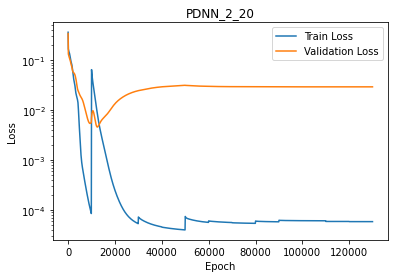

In [21]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

In [22]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=110000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [23]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 0.41085324353451336 	Loss(validation) = 0.4470402721992879
100 0.17433265096479064 	Loss(validation) = 0.14675242768166188
200 0.15856343254427432 	Loss(validation) = 0.1278152501806139
300 0.14718722541216564 	Loss(validation) = 0.12027858340192757
400 0.1378397274625383 	Loss(validation) = 0.11520015184444457
500 0.12862987889989275 	Loss(validation) = 0.10675429150607207
600 0.1185824633546059 	Loss(validation) = 0.09982581868678062
700 0.1099814637620716 	Loss(validation) = 0.09566946230165908
800 0.10382206310476096 	Loss(validation) = 0.09358280953573685
900 0.09792692801455447 	Loss(validation) = 0.0918104110472045
1000 0.091274842082173 	Loss(validation) = 0.08947038239073157
1100 0.08456440886643464 	Loss(validation) = 0.08631913443275767
1200 0.07848391200591451 	Loss(validation) = 0.08240626301971632
1300 0.07128225573256738 	Loss(validation) = 

12000 5.036085036588072e-05 	Loss(validation) = 0.004205325911439758
12100 3.785771663229894e-05 	Loss(validation) = 0.004243042028297991
12200 5.6706602122738736e-05 	Loss(validation) = 0.004355082008305819
12300 3.6902738048139375e-05 	Loss(validation) = 0.0043491051964644955
12400 3.8357019671371234e-05 	Loss(validation) = 0.004408760429778066
12500 3.601496666158606e-05 	Loss(validation) = 0.004450912060887059
12600 3.5885979882570436e-05 	Loss(validation) = 0.00450538851487487
12700 3.524223104066052e-05 	Loss(validation) = 0.0045522589918755
12800 3.5204123335953704e-05 	Loss(validation) = 0.0045953116139323845
12900 3.4624995176795754e-05 	Loss(validation) = 0.004655552367927619
13000 3.423156479972046e-05 	Loss(validation) = 0.004695224127297295
13100 6.894103260446823e-05 	Loss(validation) = 0.004749455108738931
13200 3.3337451932374156e-05 	Loss(validation) = 0.004789246340845971
13300 3.361331647768103e-05 	Loss(validation) = 0.0048431467882163156
13400 3.718710427108949e-05

23800 1.7685169288967875e-05 	Loss(validation) = 0.00746364527465397
23900 1.7223813172391088e-05 	Loss(validation) = 0.00748336348162159
24000 1.7836708190817157e-05 	Loss(validation) = 0.0075032965664574335
24100 1.7646517813751618e-05 	Loss(validation) = 0.007523009026982718
24200 1.7114983082648428e-05 	Loss(validation) = 0.0075332129930338575
24300 1.697537197392526e-05 	Loss(validation) = 0.007545339012101654
24400 1.68295318082389e-05 	Loss(validation) = 0.007561772633445725
24500 1.6773617228453254e-05 	Loss(validation) = 0.0075769428726433
24600 1.6851831928730124e-05 	Loss(validation) = 0.007591441944641382
24700 1.831961832120885e-05 	Loss(validation) = 0.007590040809242364
24800 1.6547009556704714e-05 	Loss(validation) = 0.0076212099786915006
24900 1.6434234479253605e-05 	Loss(validation) = 0.00763657583384237
25000 1.707576625868184e-05 	Loss(validation) = 0.007647625814830452
25100 1.6970900973589462e-05 	Loss(validation) = 0.007667896545009808
25200 1.6816035843302155e-0

35600 1.0875918379832174e-05 	Loss(validation) = 0.008883650048516567
35700 1.0504917388212276e-05 	Loss(validation) = 0.008883871421434432
35800 1.209221480806724e-05 	Loss(validation) = 0.008885998822269814
35900 1.0415382404853564e-05 	Loss(validation) = 0.008908616759116568
36000 1.0651132379310412e-05 	Loss(validation) = 0.00892101761536959
36100 1.2548787402070982e-05 	Loss(validation) = 0.00894370871141016
36200 1.0213127753284004e-05 	Loss(validation) = 0.008933255706607406
36300 1.0082555058203722e-05 	Loss(validation) = 0.008943426068002039
36400 1.0034907411272032e-05 	Loss(validation) = 0.008951700810919595
36500 1.3225489579924233e-05 	Loss(validation) = 0.008953587511313683
36600 1.0805057777529959e-05 	Loss(validation) = 0.008969811814892075
36700 1.0106837147710034e-05 	Loss(validation) = 0.008986531842982896
36800 1.291406559006566e-05 	Loss(validation) = 0.009007261915135284
36900 1.0422598855637723e-05 	Loss(validation) = 0.009004977486285566
37000 1.708343728497184e

47500 6.792723407417389e-06 	Loss(validation) = 0.009802619644188578
47600 6.800515908372168e-06 	Loss(validation) = 0.009809598015155178
47700 6.770565892225686e-06 	Loss(validation) = 0.009813139553376872
47800 6.725516704613113e-06 	Loss(validation) = 0.009822726349501107
47900 7.109425311147843e-06 	Loss(validation) = 0.009827177006774507
48000 1.0431668613523099e-05 	Loss(validation) = 0.009848233918013378
48100 6.883353662359687e-06 	Loss(validation) = 0.009839666108233449
48200 6.656335195889994e-06 	Loss(validation) = 0.009848557737317755
48300 7.049366361343313e-06 	Loss(validation) = 0.009853904899646633
48400 6.753380380318866e-06 	Loss(validation) = 0.00986065954303028
48500 7.90187816628799e-06 	Loss(validation) = 0.00987243044581209
48600 6.739648542201243e-06 	Loss(validation) = 0.009872286217408861
48700 9.25773817912255e-06 	Loss(validation) = 0.00987393746454808
48800 6.713242547304238e-06 	Loss(validation) = 0.009878316675393644
48900 7.5328076502210025e-06 	Loss(val

59400 7.879851249891841e-06 	Loss(validation) = 0.010456358494435785
59500 5.428986443627845e-06 	Loss(validation) = 0.010466225368278324
59600 5.3739578110209125e-06 	Loss(validation) = 0.010472829401232923
59700 5.54274676487949e-06 	Loss(validation) = 0.010474415602022393
59800 5.796772909729789e-06 	Loss(validation) = 0.010483574880126752
59900 5.352289298162246e-06 	Loss(validation) = 0.010483257805974144
60000 5.321476951781906e-06 	Loss(validation) = 0.010492271415537687
60100 5.697422474735444e-06 	Loss(validation) = 0.010489207614144232
60200 5.5177140012263535e-06 	Loss(validation) = 0.010495961194214098
60300 8.417385464436631e-06 	Loss(validation) = 0.010516974114023915
60400 8.408175070423133e-06 	Loss(validation) = 0.010511875944272723
60500 5.4399397487833115e-06 	Loss(validation) = 0.010520024620544981
60600 5.9270846017165025e-06 	Loss(validation) = 0.010518052921105076
60700 5.365007330420634e-06 	Loss(validation) = 0.010521387621024366
60800 5.862877552257704e-06 	Lo

71300 8.309885555401306e-06 	Loss(validation) = 0.01096438047687611
71400 6.529940545144217e-06 	Loss(validation) = 0.010970966785378025
71500 5.025133136687237e-06 	Loss(validation) = 0.010975315325389152
71600 4.677673934727958e-06 	Loss(validation) = 0.01097770681522499
71700 5.108948954735206e-06 	Loss(validation) = 0.010983824886377499
71800 4.809633158089801e-06 	Loss(validation) = 0.010985857492104248
71900 4.719906691539851e-06 	Loss(validation) = 0.010986247316272965
72000 5.803472180647291e-06 	Loss(validation) = 0.010992597303375363
72100 4.690187352727382e-06 	Loss(validation) = 0.010996233656167396
72200 4.72298609740834e-06 	Loss(validation) = 0.01100180066264344
72300 4.654931376486038e-06 	Loss(validation) = 0.011003027036506498
72400 5.241335596917068e-06 	Loss(validation) = 0.011007492289286283
72500 4.652118716109028e-06 	Loss(validation) = 0.011010547378303287
72600 4.6652783575770134e-06 	Loss(validation) = 0.011017989297537346
72700 8.77534625810128e-06 	Loss(vali

83300 5.041970741073767e-06 	Loss(validation) = 0.011362459652891696
83400 4.514418062567188e-06 	Loss(validation) = 0.011377888640542264
83500 5.383581081815734e-06 	Loss(validation) = 0.011384189485000485
83600 4.342096300069612e-06 	Loss(validation) = 0.011386128690979378
83700 4.334020648988462e-06 	Loss(validation) = 0.011386824985538864
83800 5.325581417949641e-06 	Loss(validation) = 0.011399147122443585
83900 4.276627006540713e-06 	Loss(validation) = 0.011392882554082003
84000 4.349070296210854e-06 	Loss(validation) = 0.011395077783201462
84100 4.274449515352651e-06 	Loss(validation) = 0.011401658677619891
84200 4.343164253163568e-06 	Loss(validation) = 0.011404923505091496
84300 5.865538610364844e-06 	Loss(validation) = 0.011428629354131897
84400 4.272218867029715e-06 	Loss(validation) = 0.01141304407241073
84500 4.307212648883172e-06 	Loss(validation) = 0.011417343483272394
84600 4.3243224847546726e-06 	Loss(validation) = 0.011417392962397977
84700 4.277878269053775e-06 	Loss(

95300 4.051876184911917e-06 	Loss(validation) = 0.01172635364857488
95400 5.50947612051616e-06 	Loss(validation) = 0.011742609198703412
95500 3.988953840302042e-06 	Loss(validation) = 0.011727997317356983
95600 3.936193469812681e-06 	Loss(validation) = 0.011732970912895631
95700 3.921004816368658e-06 	Loss(validation) = 0.011734396463163665
95800 3.963762333219056e-06 	Loss(validation) = 0.011740684995584089
95900 3.918124362447659e-06 	Loss(validation) = 0.011739891372586015
96000 3.916283613275679e-06 	Loss(validation) = 0.011742751670666142
96100 3.980123198949983e-06 	Loss(validation) = 0.011742558589428307
96200 4.092715048557578e-06 	Loss(validation) = 0.011752854026879494
96300 3.915471939765628e-06 	Loss(validation) = 0.01175202568071602
96400 3.959700046974178e-06 	Loss(validation) = 0.011751033281329225
96500 4.054873787380859e-06 	Loss(validation) = 0.011753037371068533
96600 4.236753191832167e-06 	Loss(validation) = 0.011758683641840817
96700 3.901340392455269e-06 	Loss(val

107100 3.857851940700959e-06 	Loss(validation) = 0.012022586358630023
107200 3.7244840638382932e-06 	Loss(validation) = 0.012029280887532738
107300 3.729580588511449e-06 	Loss(validation) = 0.012027853194242254
107400 3.818446273575053e-06 	Loss(validation) = 0.012032992094642744
107500 3.793127959111036e-06 	Loss(validation) = 0.012031204267893477
107600 3.830886882937724e-06 	Loss(validation) = 0.012037298986877706
107700 4.757866451383896e-06 	Loss(validation) = 0.012048749463899607
107800 3.6711173663891583e-06 	Loss(validation) = 0.012040359311228955
107900 3.6675647114727857e-06 	Loss(validation) = 0.01204577854120425
108000 3.7410324995358154e-06 	Loss(validation) = 0.012050410299338538
108100 5.227332135928496e-06 	Loss(validation) = 0.012059478238523358
108200 3.7503871420821913e-06 	Loss(validation) = 0.012052631122146338
108300 3.6816711264148593e-06 	Loss(validation) = 0.01205448505711564
108400 3.6801825799759145e-06 	Loss(validation) = 0.012059264835274766
108500 3.856100

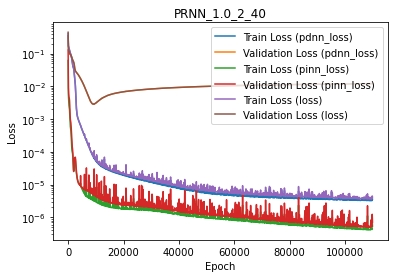

In [24]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

In [25]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN(f"PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2,
                                    num_without_snapshots=225)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=110000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [26]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 0.10938098268834669 	Loss(validation) = 0.06763237098495341
100 0.004467018284006059 	Loss(validation) = 0.005199183594299188
200 0.003575904734849738 	Loss(validation) = 0.004152054344825476
300 0.002909156683181293 	Loss(validation) = 0.003299360790744283
400 0.0023501920163780956 	Loss(validation) = 0.002557048230075186
500 0.001899886163792897 	Loss(validation) = 0.0019545424212764717
600 0.0015809166520048639 	Loss(validation) = 0.0015533125037257968
700 0.0013444530904148312 	Loss(validation) = 0.0012974547479701096
800 0.0011343296137764722 	Loss(validation) = 0.0010986092616030896
900 0.0009223956652732578 	Loss(validation) = 0.0009057242175523647
1000 0.0007067198705451642 	Loss(validation) = 0.0007078407808703741
1100 0.0005115179991336756 	Loss(validation) = 0.0005259461155329167
1200 0.00036413787859554224 	Loss(validation) = 0.0003858094868991

11600 2.453602790006522e-06 	Loss(validation) = 2.893873191550409e-06
11700 2.6609030687499735e-06 	Loss(validation) = 2.964592971780948e-06
11800 2.3788491194185194e-06 	Loss(validation) = 2.8034520316669276e-06
11900 2.5288988051916715e-06 	Loss(validation) = 2.8810991614480267e-06
12000 2.311252984324789e-06 	Loss(validation) = 2.7200264844934002e-06
12100 2.7919497611407242e-06 	Loss(validation) = 2.970629521270788e-06
12200 2.3609603360646833e-06 	Loss(validation) = 2.6937233560508967e-06
12300 2.5482491912122735e-06 	Loss(validation) = 3.186292449834219e-06
12400 2.187361282778174e-06 	Loss(validation) = 2.5689718587727364e-06
12500 2.1609504484453174e-06 	Loss(validation) = 2.570038202285497e-06
12600 4.637337798337506e-06 	Loss(validation) = 4.870783867198675e-06
12700 2.105218377760577e-06 	Loss(validation) = 2.46789824979897e-06
12800 3.8106081404740554e-06 	Loss(validation) = 3.7272363710902242e-06
12900 2.054722832343154e-06 	Loss(validation) = 2.406717004663791e-06
13000 2

23200 1.251342793514645e-06 	Loss(validation) = 1.5490695182102695e-06
23300 7.646294208822978e-07 	Loss(validation) = 8.739535500780668e-07
23400 7.674490708334481e-07 	Loss(validation) = 8.828804473964149e-07
23500 7.525874739937989e-07 	Loss(validation) = 8.621927013645388e-07
23600 1.0475109236890503e-06 	Loss(validation) = 1.3740966906702707e-06
23700 7.394736127094617e-07 	Loss(validation) = 8.446062635198504e-07
23800 7.479798277261356e-07 	Loss(validation) = 8.552026426798051e-07
23900 7.311711047243142e-07 	Loss(validation) = 8.368134452078968e-07
24000 7.217539772293474e-07 	Loss(validation) = 8.260500502743139e-07
24100 7.394145830360628e-07 	Loss(validation) = 8.436922862194356e-07
24200 7.095892710864949e-07 	Loss(validation) = 8.115203593659536e-07
24300 7.212834917277933e-07 	Loss(validation) = 8.229490509592209e-07
24400 3.096192230483452e-06 	Loss(validation) = 1.7682580083190822e-06
24500 6.932239696910188e-07 	Loss(validation) = 7.933727972131099e-07
24600 7.85193777

34900 3.459220831084157e-07 	Loss(validation) = 3.990478569753538e-07
35000 3.455349513301672e-07 	Loss(validation) = 3.960743679904654e-07
35100 4.40096283522742e-07 	Loss(validation) = 4.1423580262706574e-07
35200 3.661052736695055e-07 	Loss(validation) = 4.6296799291021927e-07
35300 5.331521875737481e-07 	Loss(validation) = 6.174146891254265e-07
35400 3.361718151881339e-07 	Loss(validation) = 3.896268267232068e-07
35500 3.3452473294612963e-07 	Loss(validation) = 3.873890378812044e-07
35600 3.5158458586195e-07 	Loss(validation) = 3.923621963549809e-07
35700 6.525395671367169e-07 	Loss(validation) = 4.851419831849039e-07
35800 3.2936174646350253e-07 	Loss(validation) = 3.8185255245835614e-07
35900 3.272745866362585e-07 	Loss(validation) = 3.773504535166011e-07
36000 3.276491590069348e-07 	Loss(validation) = 3.7483380428139447e-07
36100 3.2441545846382437e-07 	Loss(validation) = 3.768166684397129e-07
36200 3.2731743258465867e-07 	Loss(validation) = 3.757136651604119e-07
36300 3.3109447

46500 2.1229426481700892e-07 	Loss(validation) = 2.3528599867338894e-07
46600 1.8657354307417906e-06 	Loss(validation) = 1.1833853061423918e-06
46700 2.082705749972806e-07 	Loss(validation) = 2.3530752498513836e-07
46800 3.4655385614891025e-07 	Loss(validation) = 3.1639404859845886e-07
46900 2.069298387610164e-07 	Loss(validation) = 2.3406296278088004e-07
47000 2.073515017350435e-07 	Loss(validation) = 2.33660441697016e-07
47100 2.5772182388242395e-07 	Loss(validation) = 2.3348729221537293e-07
47200 2.0514408542312185e-07 	Loss(validation) = 2.3131152114438678e-07
47300 2.0589544410369473e-07 	Loss(validation) = 2.294994469842521e-07
47400 2.3588096262353008e-07 	Loss(validation) = 2.3801931786363227e-07
47500 2.0548633376375696e-07 	Loss(validation) = 2.345586281759297e-07
47600 2.029882407348187e-07 	Loss(validation) = 2.2940330153146266e-07
47700 2.0481188616032375e-07 	Loss(validation) = 2.295154536335546e-07
47800 1.4554698501574236e-06 	Loss(validation) = 6.965855089646444e-07
47

58100 1.5773388391414326e-07 	Loss(validation) = 1.7597952667898462e-07
58200 1.5789311953233917e-07 	Loss(validation) = 1.755568312711515e-07
58300 1.9706409728620328e-07 	Loss(validation) = 1.967180382422946e-07
58400 2.7776415367516917e-07 	Loss(validation) = 3.194611745294195e-07
58500 1.5653740845856232e-07 	Loss(validation) = 1.7405505882883328e-07
58600 1.5722640041616968e-07 	Loss(validation) = 1.7419872915696908e-07
58700 1.7485036136634182e-07 	Loss(validation) = 1.9225579804249554e-07
58800 1.7923517835218522e-07 	Loss(validation) = 2.0568156618579712e-07
58900 1.5511377590729137e-07 	Loss(validation) = 1.728667267700396e-07
59000 1.5595236884893811e-07 	Loss(validation) = 1.718754645095717e-07
59100 1.6734972588674975e-07 	Loss(validation) = 1.8119661264165803e-07
59200 3.3194718187896376e-07 	Loss(validation) = 2.531927464531827e-07
59300 1.5385672386978677e-07 	Loss(validation) = 1.7155465821971037e-07
59400 1.5475507221585333e-07 	Loss(validation) = 1.7039578663033702e-0

69600 1.263415757937743e-07 	Loss(validation) = 1.4194192589516166e-07
69700 1.2714106247098526e-07 	Loss(validation) = 1.4263634750662943e-07
69800 1.2681767225450001e-07 	Loss(validation) = 1.4400510981819444e-07
69900 1.2583714696770178e-07 	Loss(validation) = 1.4178903988492545e-07
70000 4.2120570831071577e-07 	Loss(validation) = 3.3036051318737286e-07
70100 1.2522880835985023e-07 	Loss(validation) = 1.4080658562942976e-07
70200 1.3549493895729914e-07 	Loss(validation) = 1.4709864181248444e-07
70300 1.249488858230317e-07 	Loss(validation) = 1.4121581156722545e-07
70400 1.2463605780392876e-07 	Loss(validation) = 1.406701196038827e-07
70500 1.2631805227489113e-07 	Loss(validation) = 1.4277650711727033e-07
70600 1.2416268661462553e-07 	Loss(validation) = 1.39313447784713e-07
70700 1.241449136438996e-07 	Loss(validation) = 1.3896636525355789e-07
70800 6.681256833127976e-07 	Loss(validation) = 6.896483218223049e-07
70900 1.2344069682017497e-07 	Loss(validation) = 1.3894491249061334e-07


81100 1.0386062032870071e-07 	Loss(validation) = 1.196000255605488e-07
81200 1.0428135842847688e-07 	Loss(validation) = 1.1867278253598957e-07
81300 1.0354770752396758e-07 	Loss(validation) = 1.1927257246337972e-07
81400 1.0636080774753108e-07 	Loss(validation) = 1.1947391077875475e-07
81500 1.0320451209023905e-07 	Loss(validation) = 1.1893714341268823e-07
81600 1.0738441322994898e-07 	Loss(validation) = 1.196128371155433e-07
81700 1.029059982928867e-07 	Loss(validation) = 1.1866909541257687e-07
81800 1.0420096171890946e-07 	Loss(validation) = 1.1841710107163646e-07
81900 1.0254559323584742e-07 	Loss(validation) = 1.1830869044263557e-07
82000 1.0853313141988733e-07 	Loss(validation) = 1.2133674531203754e-07
82100 2.4702429736025954e-07 	Loss(validation) = 2.5688416214421564e-07
82200 1.0212398921425032e-07 	Loss(validation) = 1.1787591450335809e-07
82300 2.4643078954419635e-07 	Loss(validation) = 2.2660485256823634e-07
82400 1.0177481188826003e-07 	Loss(validation) = 1.1758753988526712

92700 9.023454894460281e-08 	Loss(validation) = 1.0422594842045115e-07
92800 8.711484879985229e-08 	Loss(validation) = 1.0380071984244096e-07
92900 1.0294345595362208e-07 	Loss(validation) = 1.2004922062993183e-07
93000 8.688680376164025e-08 	Loss(validation) = 1.0361764904290626e-07
93100 1.1752164137899407e-07 	Loss(validation) = 1.0508948213192777e-07
93200 8.663304792420071e-08 	Loss(validation) = 1.0341440782401914e-07
93300 9.584480690433817e-08 	Loss(validation) = 1.0415818257793287e-07
93400 8.810959956452999e-08 	Loss(validation) = 1.285581636759116e-07
93500 8.628110917088669e-08 	Loss(validation) = 1.0292594812840793e-07
93600 1.298570013443518e-07 	Loss(validation) = 1.2261327747050887e-07
93700 8.602099446113663e-08 	Loss(validation) = 1.0281133008409538e-07
93800 7.309717034744837e-07 	Loss(validation) = 6.17760401560158e-07
93900 8.581910403649766e-08 	Loss(validation) = 1.0276765295288074e-07
94000 8.630945913013747e-08 	Loss(validation) = 1.0392417991801878e-07
94100 8

104300 7.46517566938117e-08 	Loss(validation) = 9.223199916940397e-08
104400 8.717444212238754e-08 	Loss(validation) = 1.0614105566395552e-07
104500 7.439100021795682e-08 	Loss(validation) = 9.213057968954898e-08
104600 7.484801231438928e-08 	Loss(validation) = 9.192173404938128e-08
104700 7.584807966060787e-08 	Loss(validation) = 9.524392217238736e-08
104800 7.413824531796855e-08 	Loss(validation) = 9.195567610056386e-08
104900 8.453855524823329e-08 	Loss(validation) = 1.0090155150382446e-07
105000 7.390598581665162e-08 	Loss(validation) = 9.16555681837925e-08
105100 7.793108631589096e-08 	Loss(validation) = 1.016019637003245e-07
105200 7.373389140228261e-08 	Loss(validation) = 9.147645460135182e-08
105300 8.17084616522874e-08 	Loss(validation) = 9.984906542917532e-08
105400 7.354632763876808e-08 	Loss(validation) = 9.14117192582924e-08
105500 7.405446411358868e-08 	Loss(validation) = 9.110831588749593e-08
105600 7.352713729005446e-08 	Loss(validation) = 9.166270463076504e-08
105700 7

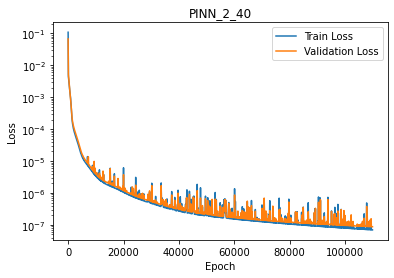

In [27]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [28]:
np.random.seed(0)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [29]:
pdnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	9.359687281346595e-06	9.284855603575538e-06	6.434592853527454e-07
mean	0.006132540078242927	0.00613253875205727	3.3013859995409186e-05
max	0.09016125799141263	0.0900797358935332	0.0004579787893812122


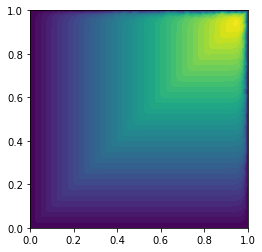

In [37]:
mu_ = torch.tensor([6.])
solution = pdnn_net.solve(mu_, input_normalization_pdnn, output_normalization_pdnn)#output_normalization_pdnn(pdnn_net(input_normalization_pdnn(mu_)).T, normalize=False)
plot(solution, reduced_problem=reduced_problem)

In [30]:
prnn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	2.713160600192036e-05	2.6983092800945746e-05	6.434592853527454e-07
mean	0.0019469631667806888	0.001946709617398636	3.3013859995409186e-05
max	0.020678781307154247	0.02069846806884139	0.0004579787893812122


In [31]:
pinn_net.load_best_weights()
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 15 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0011354817114049818	0.0011354281215206752	6.434592853527454e-07
mean	0.004098554153803321	0.004099507657530164	3.3013859995409186e-05
max	0.007813790752971894	0.00781368677015625	0.0004579787893812122
